In [1]:
from matplotlib import pyplot as plt 
from lines_generator import *
from hough import *
import numpy as np
import cv2
#import keras

## Lines Generator

In [2]:
%%time
lines,ims = im_generator(10)

CPU times: user 2.28 s, sys: 270 ms, total: 2.55 s
Wall time: 3.34 s


## Binary Images

In [3]:
%%time
#Threshold
#ims_bin = [(im>230)*255 for im in ims]
ims_bin = [bin_im2(im) for im in ims]
ims_bin = np.array(ims_bin)

CPU times: user 560 ms, sys: 2.82 ms, total: 563 ms
Wall time: 720 ms


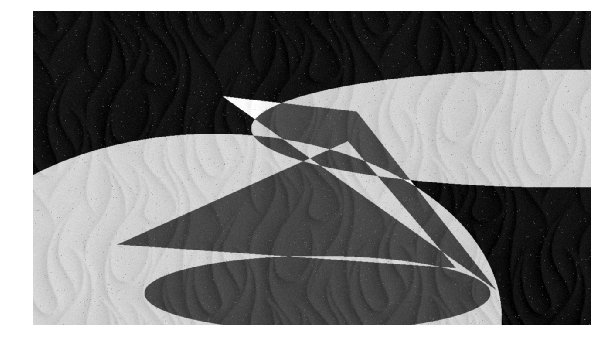

In [4]:
imshow(ims[0])

## Show

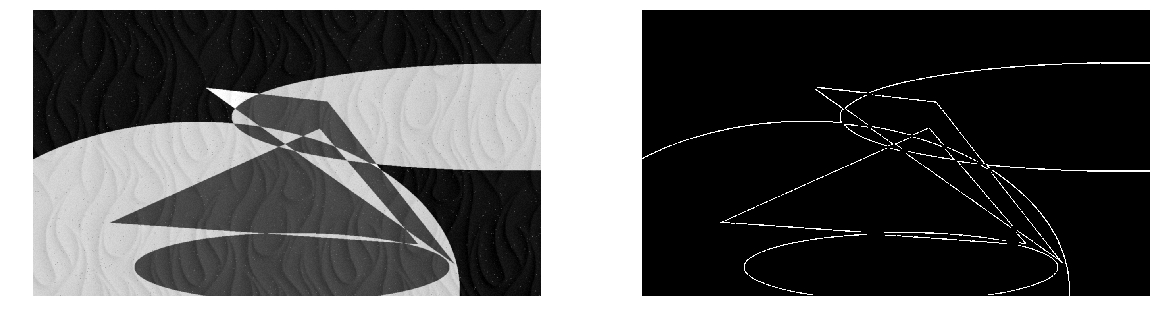

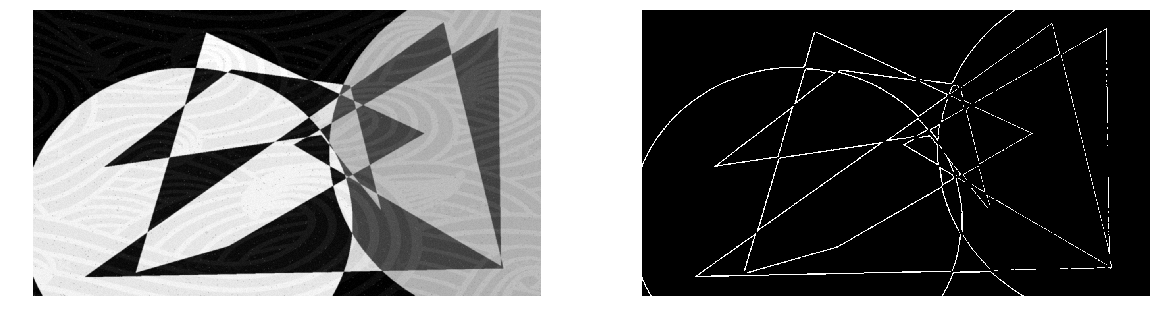

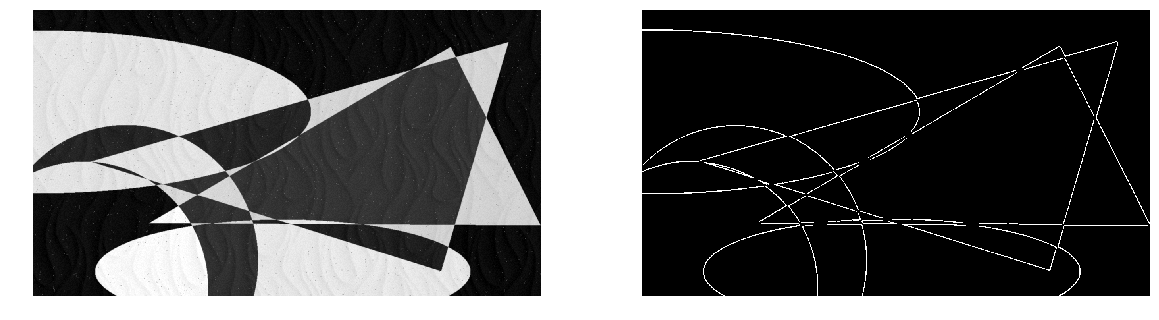

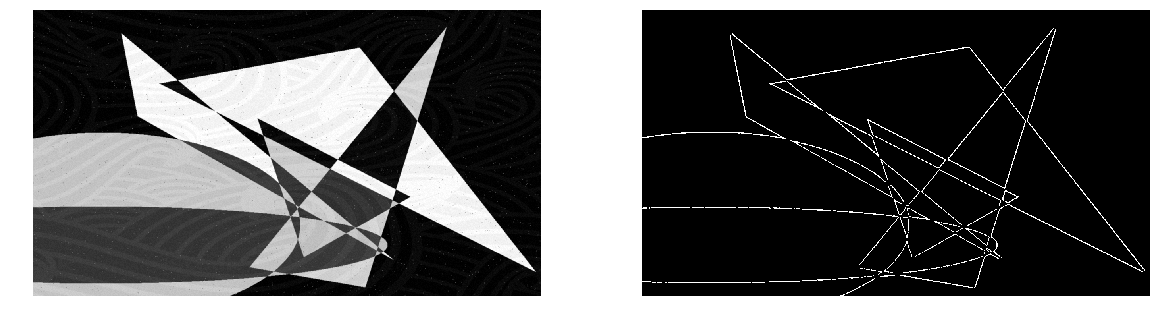

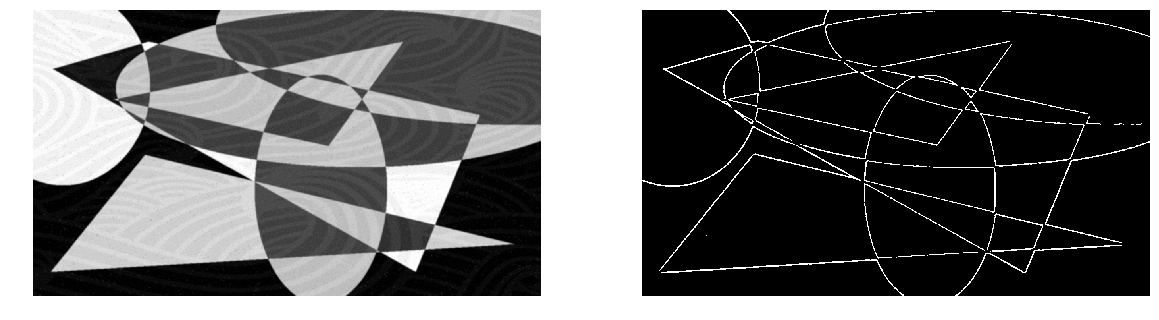

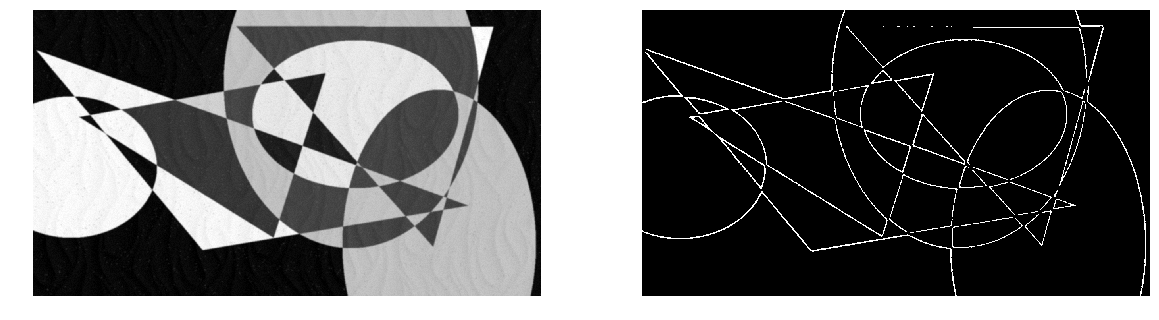

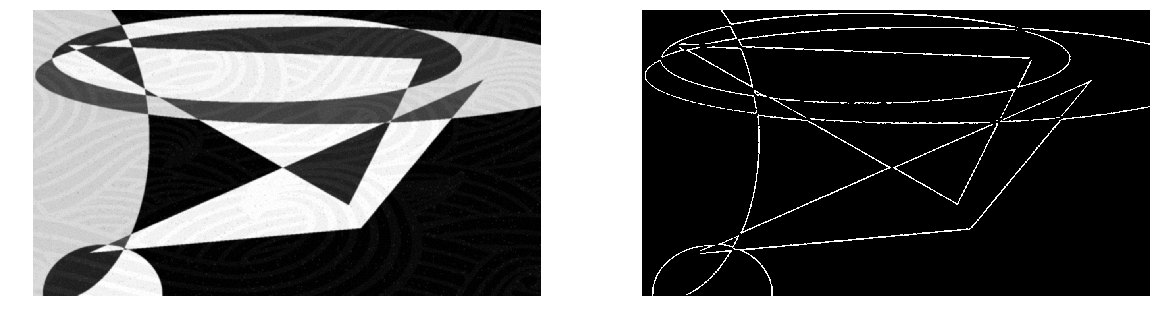

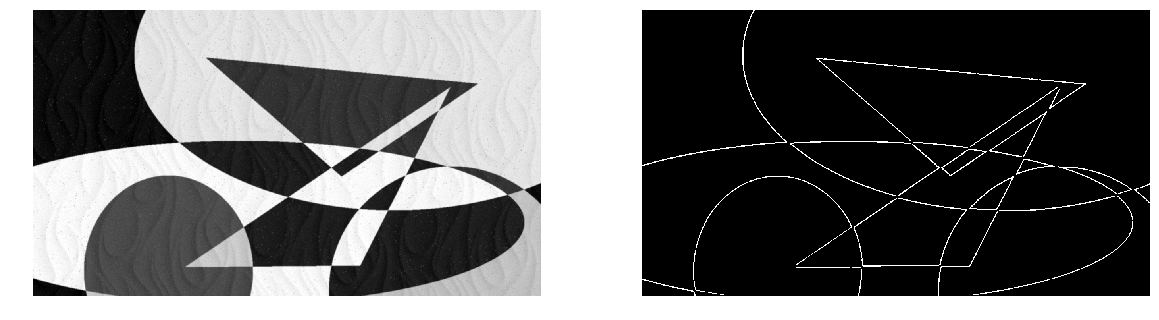

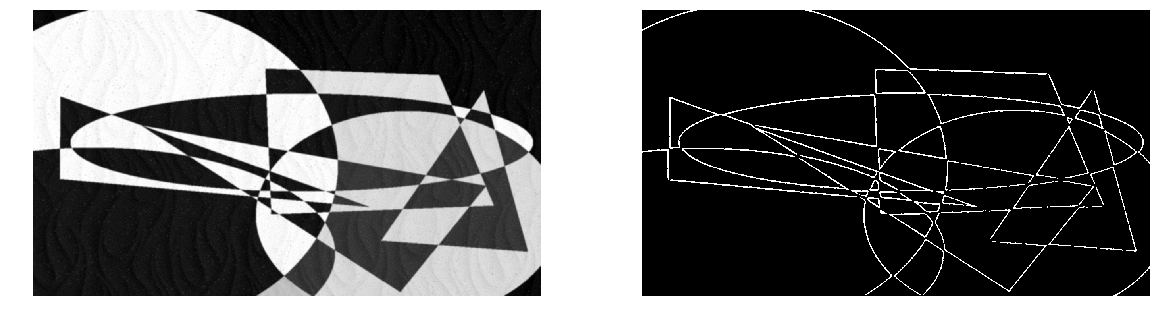

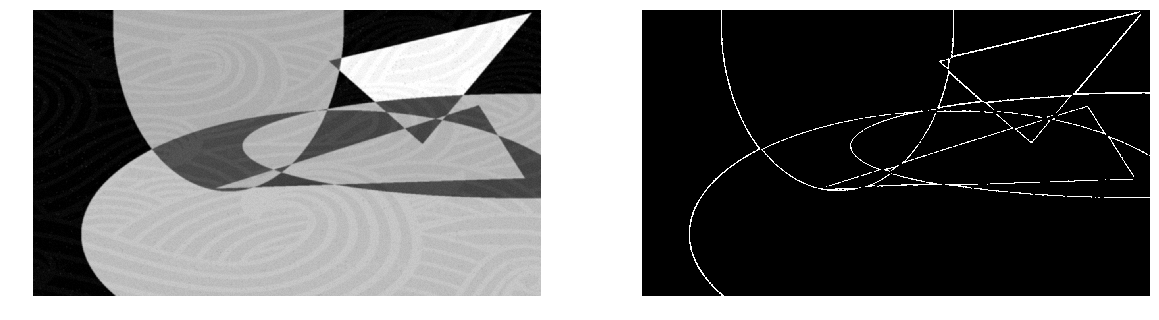

In [5]:
for im,imb in zip(ims,ims_bin):
    imshow2(im,imb)

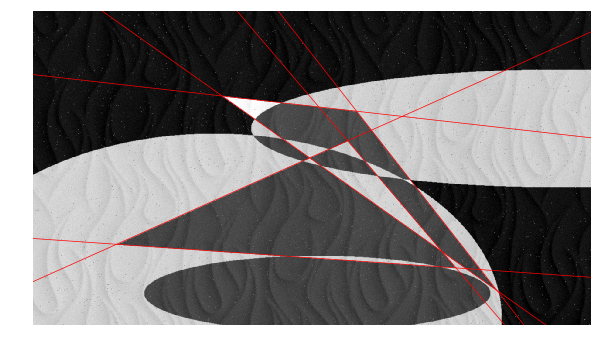

In [6]:
plot_lines(ims[0],lines[0][0],lines[0][1])

## Hough

In [7]:
%%time
delta_angle = np.pi/3000
ims_hough = list()
for im in ims_bin:
    h, theta, d = hough_line(im,np.arange(-np.pi/2,np.pi/2,delta_angle))
    ims_hough.append(h.astype('uint16'))
ims_hough = np.array(ims_hough)
ims_hough[0].shape

CPU times: user 6.31 s, sys: 244 ms, total: 6.56 s
Wall time: 6.56 s


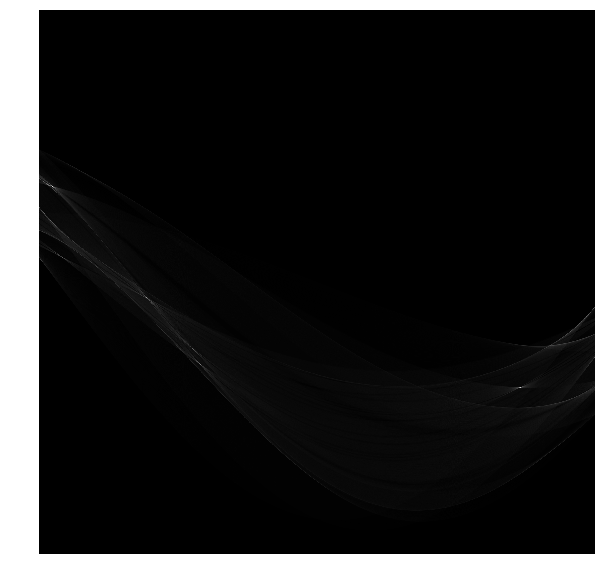

In [8]:
imshow(ims_hough[0])

## Hough mask

In [9]:
max_dist = np.sqrt(ims.shape[1]**2+ims.shape[2]**2)
masks = np.zeros(ims_hough.shape).astype('uint8')

for i in range(len(lines)):
    
    dists = lines[i][0].copy()
    angles = lines[i][1].copy()
    
    #dist to pixels
    dists = dists+max_dist
    dists[angles<0] = 2*max_dist-dists[angles<0]
    ys = np.round(dists).astype('int')
    
    #angle to pixels
    angles[angles>0] = np.pi-angles[angles>0]
    angles = np.abs(angles)
    xs = np.round(angles/delta_angle).astype('int')

    masks[i,ys,xs] = 1
    
    #dilate
    kernel = np.ones((3,3),np.uint8)
    masks[i] = cv2.dilate(masks[i],kernel,iterations = 1)

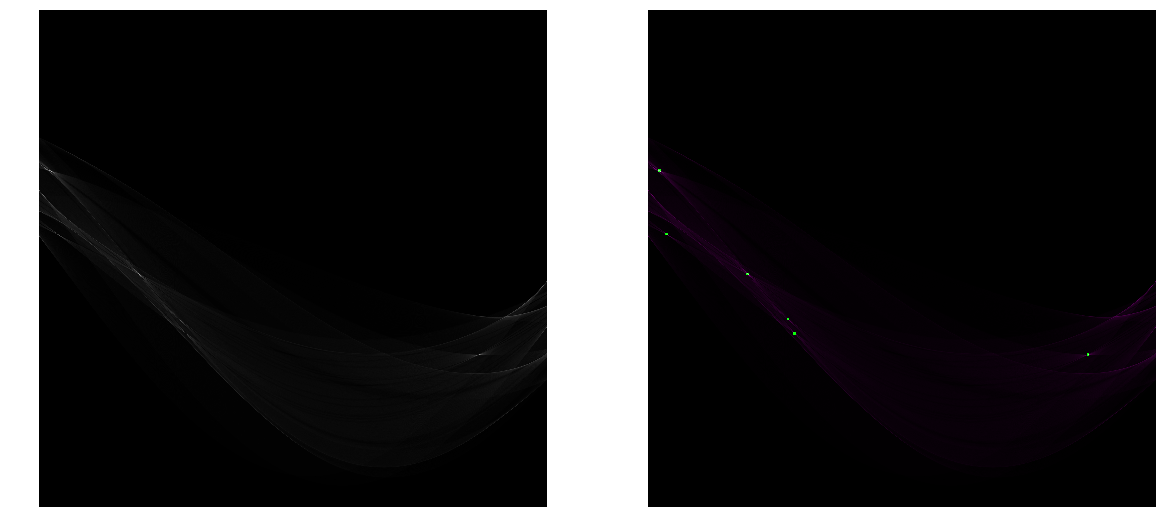

In [10]:
#dilate mask
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(masks[0],kernel,iterations = 3)
# to gray [0,1)
im_gray = ims_hough[0].astype('float32')/ims_hough[0].max()
# to rgb
im_rgb = cv2.cvtColor(im_gray,cv2.COLOR_GRAY2RGB)
#show
im_pts = im_rgb.copy()
im_pts[:,:,1] = dilation
imshow2(im_rgb,im_pts)

## Skimage Peaks

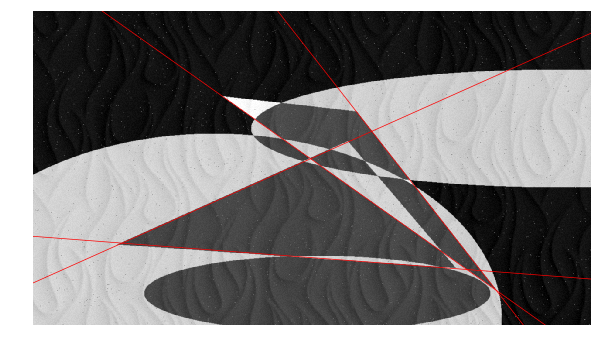

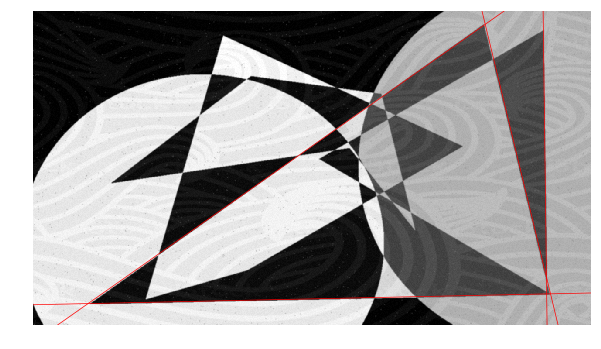

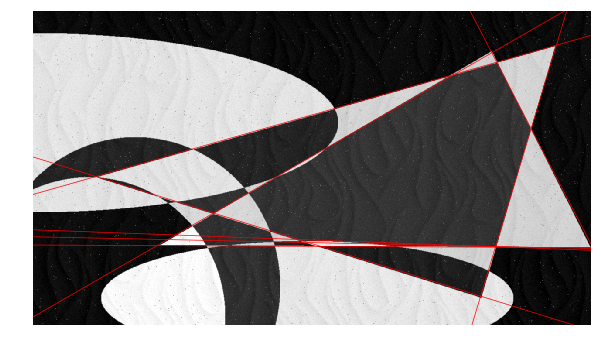

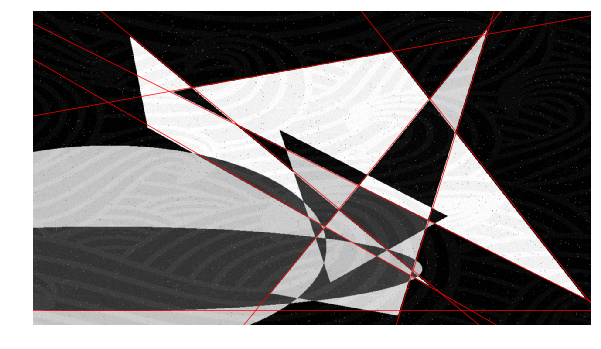

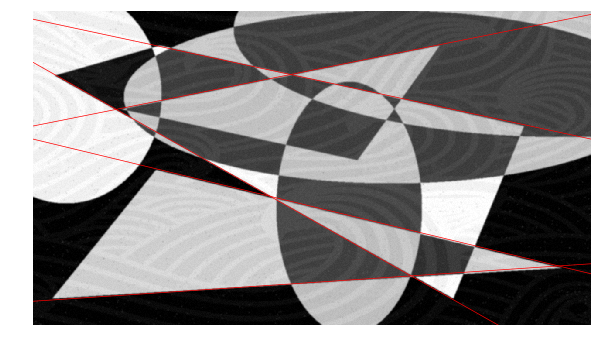

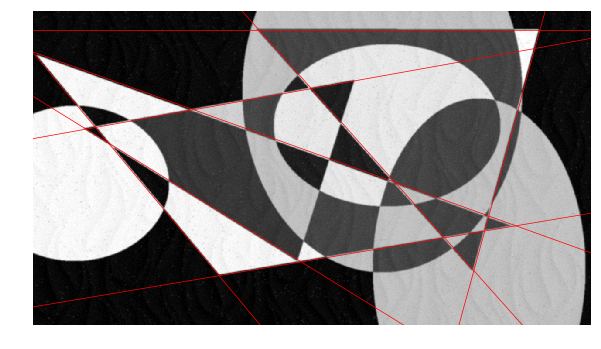

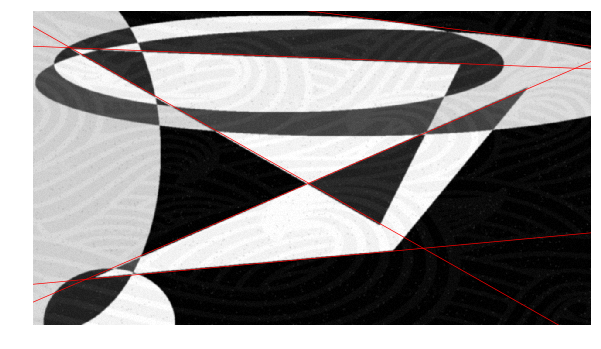

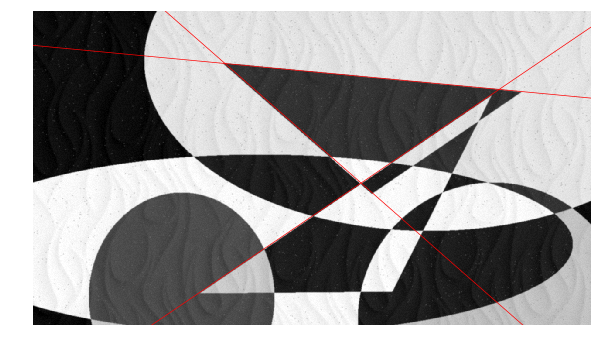

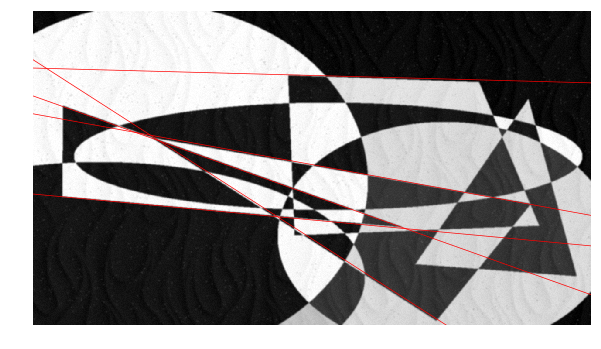

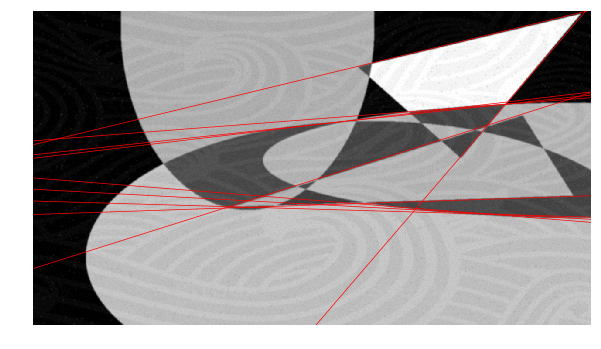

CPU times: user 8.3 s, sys: 2.25 s, total: 10.6 s
Wall time: 8.83 s


In [11]:
%%time
for im_h,im in zip(ims_hough, ims):
    _, angles, dists = hough_line_peaks(im_h,  theta, d)
    plot_lines(im,dists,np.pi/2-angles)

## Patches

In [12]:
patche_size = 17
min_pixels = 200
prob_to_save = 1e-4

In [13]:
%%time

#variables
half = int(patche_size/2)
shape = ims_hough[0].shape
k = 0

for im_h,mask in zip(ims_hough,masks):
    #print
    k+=1
    print(k,'/',masks.shape[0], end = '')
    
    patches = list()
    Y = list()
    #for pixel
    for i in range(half,shape[0]-half):#rows
        for j in range(half,shape[1]-half):#cols
            #cut
            im = im_h[ i-half:i+half+1 , j-half:j+half+1 ]
            
            prob =np.random.random()
            # so weak
            if not mask[i,j] and \
                ((im.sum() < min_pixels) or \
                (prob_to_save < prob)):
                continue 
            #save
            patches.append(im)
            Y.append(mask[i,j])
    
    
    patches = np.array(patches)
    Y = np.array(Y)
    
    #save
    print('  data/patches'+str(k)+'.npy')
    np.save('data/patches'+str(k),patches)
    np.save('data/Y'+str(k),Y)

1 / 10  data/patches1.npy
2 / 10  data/patches2.npy
3 / 10  data/patches3.npy
4 / 10  data/patches4.npy
5 / 10  data/patches5.npy
6 / 10  data/patches6.npy
7 / 10  data/patches7.npy
8 / 10  data/patches8.npy
9 / 10  data/patches9.npy
10 / 10  data/patches10.npy
CPU times: user 11min 58s, sys: 6.34 s, total: 12min 4s
Wall time: 11min 55s
